In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, auc
from joblib import dump


       Air_temperature__K_  Process_temperature__K_  Rotational_speed__rpm_  \
count          4500.000000              4500.000000             4500.000000   
mean            299.996556               310.009778             1536.262444   
std               2.010496                 1.485834              175.844128   
min             295.300000               305.700000             1183.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.000000               310.100000             1502.500000   
75%             301.500000               311.100000             1609.000000   
max             304.500000               313.800000             2886.000000   

       Torque__Nm_  Tool_wear__min_  Machine_failure  
count  4500.000000      4500.000000      4500.000000  
mean     40.056933       108.555556         0.034222  
std       9.830849        63.585317         0.181820  
min       3.800000         0.000000         0.000000  
25%      33.3

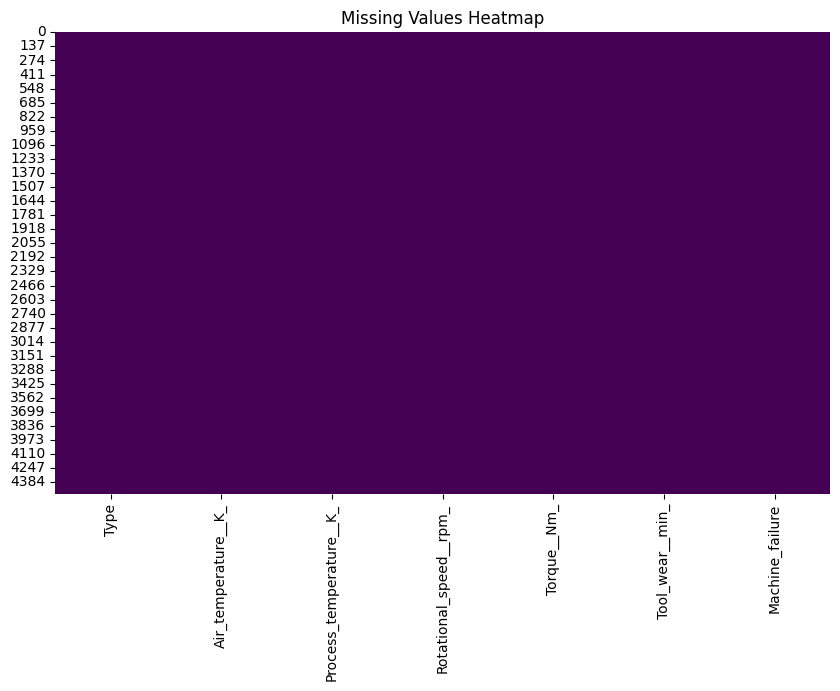

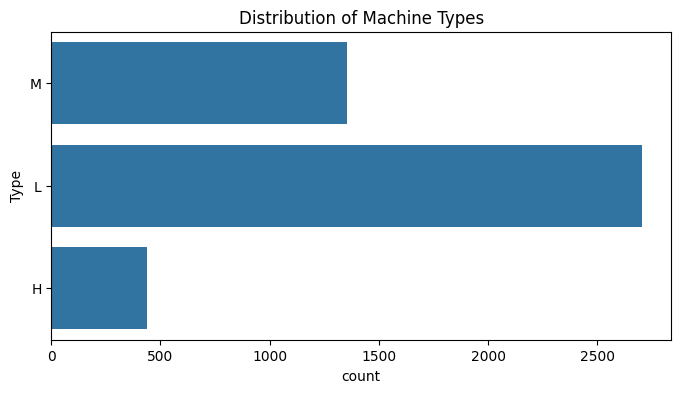

In [28]:
# Load the dataset from a CSV file into a pandas DataFrame
data = pd.read_csv('ai4i2020.csv')

# Show basic statistics like mean, min, max, etc. for all numerical columns
print(data.describe())

# Check for any missing values in each column
missing_values = data.isnull().sum()
print("Missing Values in each column:\n", missing_values)

# Visualize missing values using a heatmap (helps to see where data is missing)
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')  # Create the heatmap
plt.title("Missing Values Heatmap")  # Add a title to the plot
plt.show()  # Display the heatmap

# Show the distribution of the 'Type' column (categorical feature, like machine types)
plt.figure(figsize=(8, 4))  # Set the size of the plot
sns.countplot(data['Type'])  # Count and plot the number of each machine type
plt.title("Distribution of Machine Types")  # Add a title to the plot
plt.show()  # Display the plot


In [29]:
data.describe()

,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_,Machine_failure
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,299.996556,310.009778,1536.262444,40.056933,108.555556,0.034222
std,2.010496,1.485834,175.844128,9.830849,63.585317,0.181820
min,295.300000,305.700000,1183.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.300000,54.000000,0.000000
50%,300.000000,310.100000,1502.500000,40.100000,108.500000,0.000000
75%,301.500000,311.100000,1609.000000,46.700000,164.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000,1.000000


In [30]:
data.dtypes

Type                        object
Air_temperature__K_        float64
Process_temperature__K_    float64
Rotational_speed__rpm_       int64
Torque__Nm_                float64
Tool_wear__min_              int64
Machine_failure              int64
dtype: object

In [31]:
#drop null values
data= data.dropna()

In [32]:
data.dtypes

Type                        object
Air_temperature__K_        float64
Process_temperature__K_    float64
Rotational_speed__rpm_       int64
Torque__Nm_                float64
Tool_wear__min_              int64
Machine_failure              int64
dtype: object

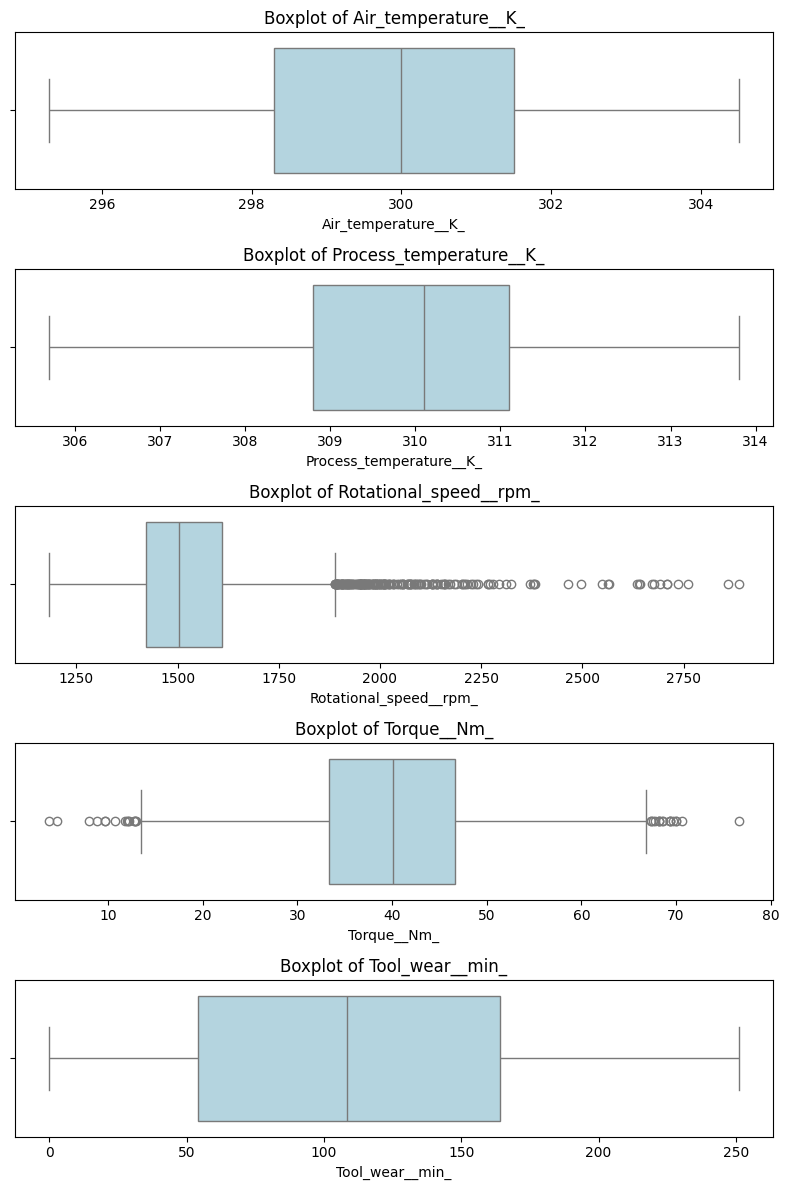

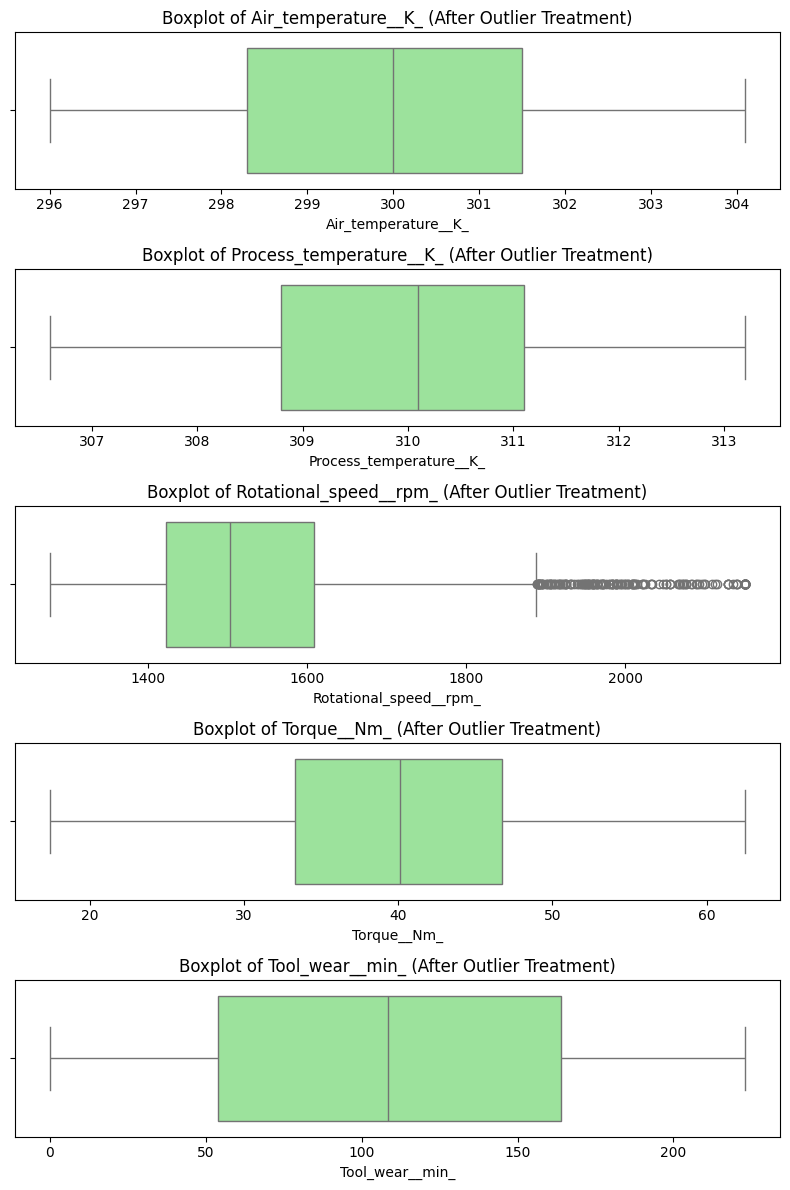

In [33]:
# Outlier detection using boxplots for numerical columns
# Listing all numerical columns where we want to check for outliers
numerical_cols = ['Air_temperature__K_', 'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_']

# Create multiple subplots for each numerical column
fig, axs = plt.subplots(len(numerical_cols), figsize=(8, 12))  # Set up subplots with the figure size
for i, col in enumerate(numerical_cols):  # Loop through each numerical column
    sns.boxplot(x=data[col], ax=axs[i], color='lightblue')  # Create a boxplot for the current column
    axs[i].set_title(f'Boxplot of {col}')  # Add title to each subplot
plt.tight_layout()  # Adjust layout so the plots don't overlap
plt.show()  # Show the boxplots

# Outlier treatment: Capping at 1st and 99th percentiles
# Here, we limit extreme outliers by capping the data within the 1st and 99th percentiles
for col in numerical_cols:  # Loop through each numerical column
    lower_bound = data[col].quantile(0.01)  # Find the value at the 1st percentile
    upper_bound = data[col].quantile(0.99)  # Find the value at the 99th percentile
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)  # Cap values outside this range

# After treating the outliers, visualize again using boxplots
fig, axs = plt.subplots(len(numerical_cols), figsize=(8, 12))  # Create subplots again for the treated data
for i, col in enumerate(numerical_cols):  # Loop through each column
    sns.boxplot(x=data[col], ax=axs[i], color='lightgreen')  # Create a new boxplot for the treated data
    axs[i].set_title(f'Boxplot of {col} (After Outlier Treatment)')  # Add title for the new plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the boxplots after outlier treatment


In [34]:
# Function to remove outliers based on the Interquartile Range (IQR)
def remove_outliers_iqr(df, columns):
    # For each column, calculate the IQR and remove the outliers
    for col in columns:
        Q1 = df[col].quantile(0.25)  # Calculate the 1st quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Calculate the 3rd quartile (75th percentile)
        IQR = Q3 - Q1  # Calculate the interquartile range (IQR)
        lower_bound = Q1 - 1.5 * IQR  # Calculate the lower bound (anything below is an outlier)
        upper_bound = Q3 + 1.5 * IQR  # Calculate the upper bound (anything above is an outlier)

        # Keep only the rows where the column values are within the bounds (i.e., remove outliers)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df  # Return the cleaned DataFrame without outliers

# List of numerical columns to check for outliers
numerical_cols = ['Air_temperature__K_', 'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_']

# Apply the remove_outliers function to clean outliers from the dataset
data_cleaned = remove_outliers_iqr(data, numerical_cols)

# Print the shape (number of rows and columns) of the dataset before and after removing outliers
print("Original data shape:", data.shape)  # Shows the size of the original dataset
print("Data shape after removing outliers:", data_cleaned.shape)  # Shows the size of the cleaned dataset

# Replace the original dataset with the cleaned data for further analysis
data = data_cleaned


Original data shape: (4500, 7)
Data shape after removing outliers: (4317, 7)


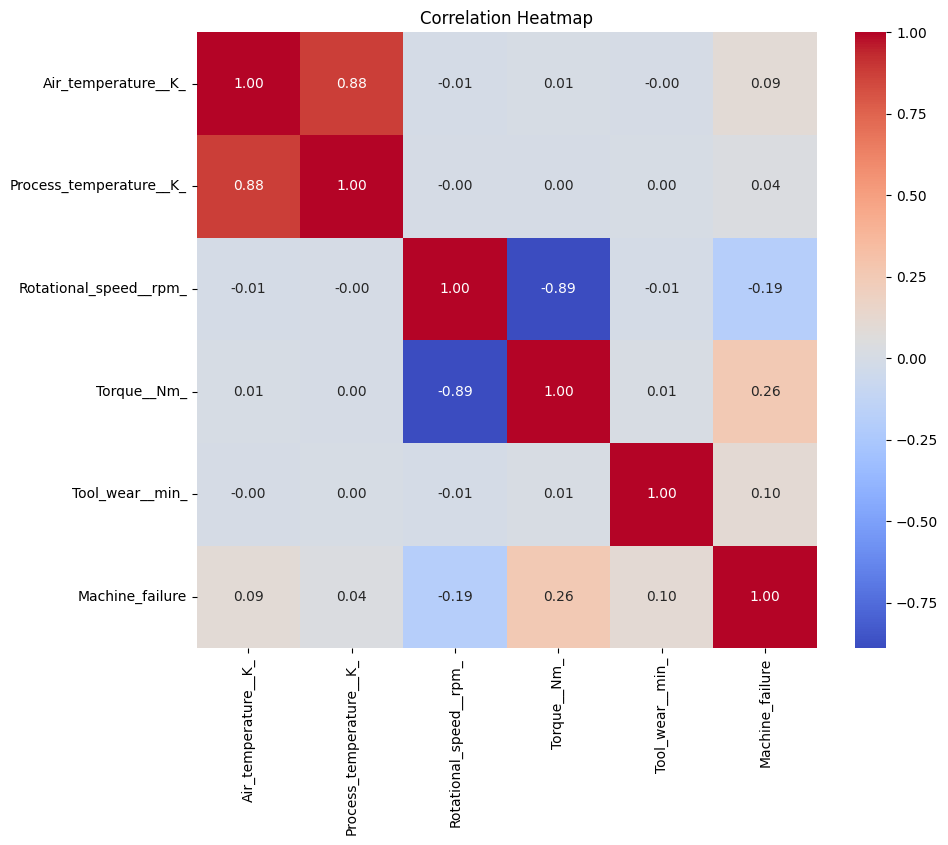

Variance Inflation Factor (VIF):
                    Feature           VIF
0                    const  51424.296103
1      Air_temperature__K_      4.308806
2  Process_temperature__K_      4.308450
3   Rotational_speed__rpm_      4.831011
4              Torque__Nm_      4.832123
5          Tool_wear__min_      1.000361
Condition Number: 358838.0556110509


In [35]:
# Correlation Heatmap for numerical features
# Create a heatmap to show the correlation between numerical columns and 'Machine_failure'
plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
correlation_matrix = data[numerical_cols + ['Machine_failure']].corr()  # Calculate the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # Plot the heatmap with annotations and color range
plt.title("Correlation Heatmap")  # Add a title to the heatmap
plt.show()  # Display the heatmap

# Variance Inflation Factor (VIF) to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Import VIF calculation function
import statsmodels.api as sm  # Import statsmodels for regression-related tasks

# Prepare the data for VIF calculation by adding a constant (intercept term)
X_vif = data[numerical_cols]
X_vif = sm.add_constant(X_vif)  # Adding a constant column to the data for VIF calculation

# Create a DataFrame to store VIF values for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns  # Add the column names
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]  # Calculate VIF for each feature
print("Variance Inflation Factor (VIF):\n", vif_data)  # Print the VIF values

# Condition number to check multicollinearity
_, s, _ = np.linalg.svd(X_vif)  # Perform Singular Value Decomposition (SVD) on the data
condition_number = np.max(s) / np.min(s)  # Calculate the condition number (max singular value / min singular value)
print(f"Condition Number: {condition_number}")  # Print the condition number


In [36]:
# Define categorical and numerical columns
# List of categorical and numerical columns in the dataset
categorical_cols = ['Type']  # Categorical column(s)
numerical_cols = ['Air_temperature__K_', 'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_']  # Numerical columns

# Preprocessing pipeline: Imputation, scaling, and one-hot encoding
# We create a preprocessing pipeline that handles missing data, scales numerical data, and encodes categorical data
preprocessor = ColumnTransformer(
    transformers=[
        # For numerical columns, we first fill missing values with the median, then scale the data
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing numerical data with the median value
            ('scaler', StandardScaler())  # Scale numerical data to have mean 0 and standard deviation 1
        ]), numerical_cols),  # Apply this pipeline to the numerical columns

        # For categorical columns, we fill missing values with the most frequent category, then encode the data
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical data with the most common value
            ('encoder', OneHotEncoder())  # Encode categorical data using one-hot encoding (convert to 0s and 1s)
        ]), categorical_cols)  # Apply this pipeline to the categorical columns
    ])


In [37]:
data.head()

,Type,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_,Machine_failure
0,M,300.7,311.9,1366.0,55.1,36,0
1,L,298.5,309.5,1547.0,33.1,68,0
2,M,300.7,310.6,1609.0,27.6,108,0
3,M,299.7,309.2,1597.0,32.9,135,0
4,L,297.9,307.6,1515.0,40.5,118,0


In [38]:
# Separate features and target variable
X = data_cleaned.drop('Machine_failure', axis=1)  # Features
y = data_cleaned['Machine_failure']  # Target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression - F1 Score: 0.2703, AUC-ROC: 0.9374, Accuracy: 0.9688


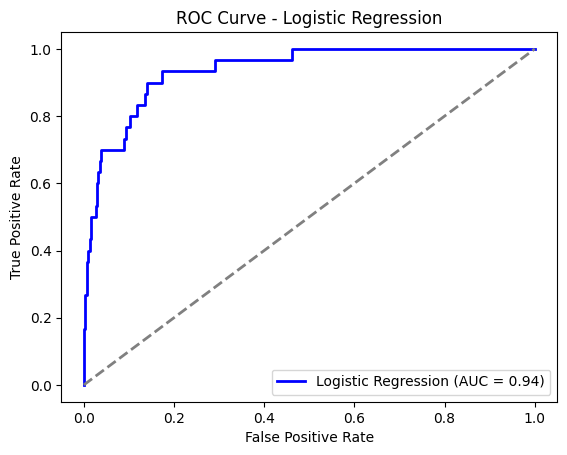

In [39]:
### Logistic Regression Model
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train Logistic Regression model
logreg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_prob_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC AUC

# Logistic Regression Evaluation
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

print(f"Logistic Regression - F1 Score: {f1_logreg:.4f}, AUC-ROC: {roc_auc_logreg:.4f}, Accuracy: {accuracy_logreg:.4f}")

# ROC Curve for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [40]:
X_train.head()

,Type,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_
293,L,300.8,311.200,1397.0,48.7,111
3581,H,304.1,313.201,1546.0,41.4,58
3673,M,301.8,311.000,1839.0,23.6,30
1956,L,302.9,312.200,1367.0,55.1,50
2124,M,303.7,312.700,1669.0,31.7,120


GBM - F1 Score: 0.5833, AUC-ROC: 0.9845, Accuracy: 0.9769


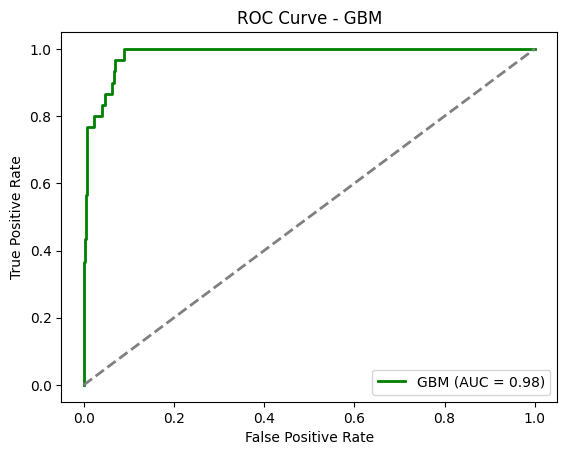

In [41]:
### Gradient Boosting Model (GBM)
gbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Train GBM model
gbm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm_pipeline.predict(X_test)
y_pred_prob_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC AUC

# GBM Evaluation
f1_gbm = f1_score(y_test, y_pred_gbm)
roc_auc_gbm = roc_auc_score(y_test, y_pred_prob_gbm)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)

print(f"GBM - F1 Score: {f1_gbm:.4f}, AUC-ROC: {roc_auc_gbm:.4f}, Accuracy: {accuracy_gbm:.4f}")

# ROC Curve for GBM
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_prob_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='green', lw=2, label=f'GBM (AUC = {roc_auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title("ROC Curve - GBM")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [42]:
### Compare Models and Pickle the Best Model
if f1_gbm > f1_logreg and roc_auc_gbm > roc_auc_logreg:
    best_model = gbm_pipeline
    print("Gradient Boosting Model selected.")
else:
    best_model = logreg_pipeline
    print("Logistic Regression Model selected.")

# Save the best model to a pickle file
dump(best_model, 'best_model.pkl')

print("Best model has been saved as best_model.pkl.")


Gradient Boosting Model selected.
Best model has been saved as best_model.pkl.
